
<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">🛠️ Importing Libraries</span>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")



<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">🛠️ Loading The data</span>


In [2]:
# Load the CSV
df = pd.read_csv('/kaggle/input/bengaluru-house-price-data/Bengaluru_House_Data.csv')

# View basic info
df.head()


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
# Shape and columns
print("Shape:", df.shape)
print("\nColumns:", df.columns)

Shape: (13320, 9)

Columns: Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')


In [4]:
# let's check each columns value counts
for columns in df.columns:
    print(df[columns].value_counts())
    print("****" * 10)

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64
****************************************
availability
Ready To Move    10581
18-Dec             307
18-May             295
18-Apr             271
18-Aug             200
                 ...  
15-Aug               1
17-Jan               1
16-Nov               1
16-Jan               1
14-Jul               1
Name: count, Length: 81, dtype: int64
****************************************
location
Whitefield                        540
Sarjapur  Road                    399
Electronic City                   302
Kanakpura Road                    273
Thanisandra                       234
                                 ... 
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
singapura paradise                  1
Abshot Layout                       1
Name: count, Length: 1305, dtype: i

In [5]:
# Drop these features (too many missing or irrelevant)
df = df.drop(['area_type','society','balcony','availability'], axis='columns')


In [6]:
# checking for missing values
df.isnull().sum()


location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [7]:
# Drop rows with missing values
df = df.dropna()


In [8]:
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64


<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">🛠️ EDA</span>


In [9]:
# Convert 'size' to numeric (e.g., '2 BHK' → 2)
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

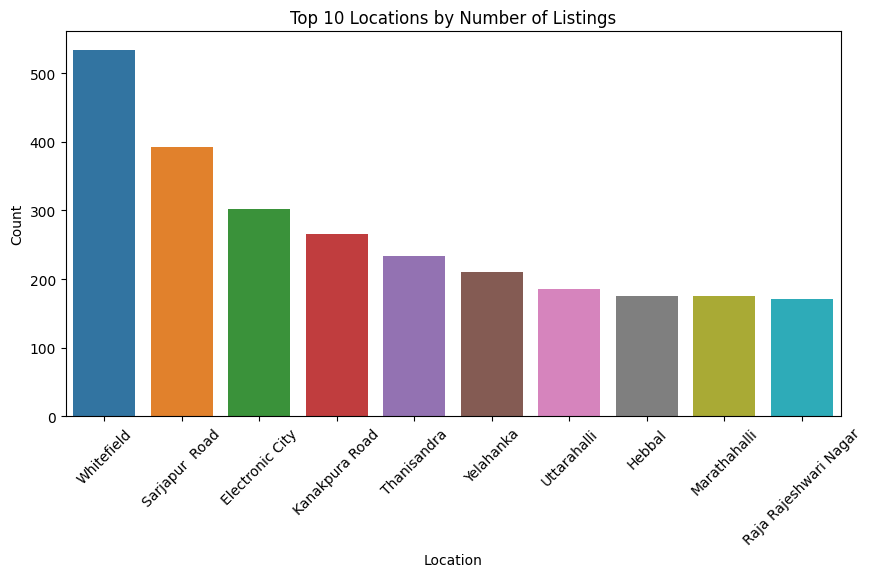

In [10]:

# 🟢 Top 10 locations with most listings
top_locations = df['location'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_locations.index, y=top_locations.values)
plt.xticks(rotation=45)
plt.title('Top 10 Locations by Number of Listings')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()


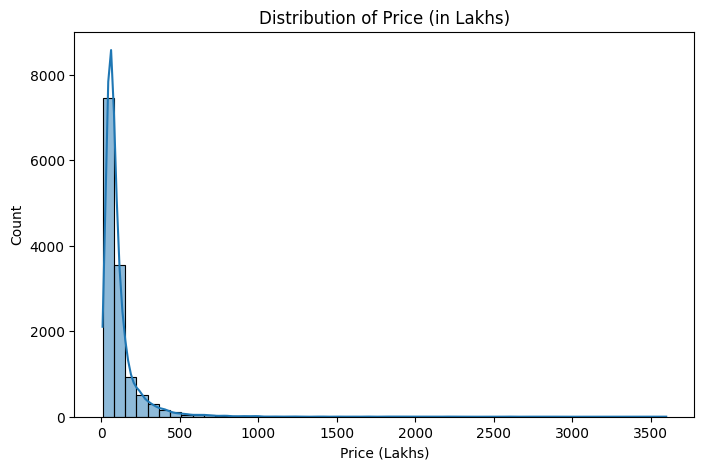

In [11]:
# 🟦 Distribution of price
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Price (in Lakhs)')
plt.xlabel('Price (Lakhs)')
plt.ylabel('Count')
plt.show()


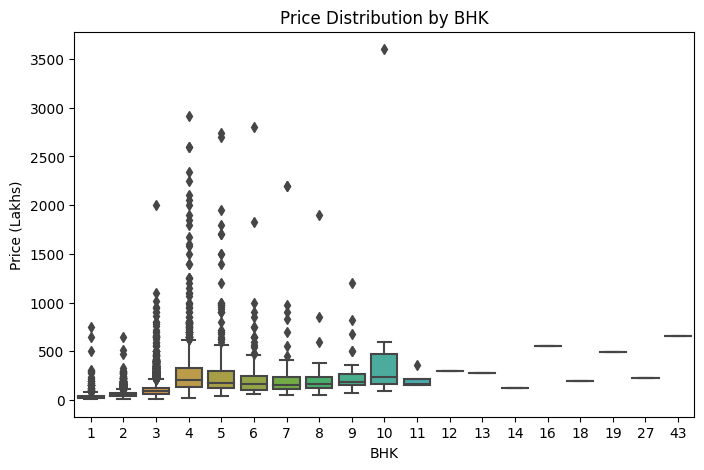

In [12]:
# 🔴 Boxplot: price vs BHK
plt.figure(figsize=(8, 5))
sns.boxplot(x='bhk', y='price', data=df)
plt.title('Price Distribution by BHK')
plt.xlabel('BHK')
plt.ylabel('Price (Lakhs)')
plt.show()


In [13]:
df.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [14]:
df.shape

(13246, 6)


<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">🛠️ Feature Engineering and Data Cleaning</span>


# 📏 Converting 'total_sqft' to Numeric Format

In [15]:
# Convert 'total_sqft' to a single numeric value
def convert_sqft_to_num(x):
    try:
        x = str(x)
        tokens = x.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1])) / 2
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)

# Drop rows with invalid or null 'total_sqft'
df = df.dropna(subset=['total_sqft'])

print("After sqft conversion:", df.shape)


After sqft conversion: (13200, 6)


# 💰 Calculating Price per Square Foot

In [16]:
# Add new column: price per square foot
df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']

#Price = 50 (lakhs) → ₹50 × 100,000 = ₹5,000,000

#Total Sqft = 1000

# price_per_sqft = 5,000,000 / 1000 = ₹5000 per sqft

# 📍 Cleaning and Grouping Location Data

In [17]:

# Clean 'location' text
df['location'] = df['location'].apply(lambda x: x.strip())

# Group rare locations as 'other'
location_counts = df['location'].value_counts()
rare_locations = location_counts[location_counts <= 10].index
df['location'] = df['location'].apply(lambda x: 'other' if x in rare_locations else x)

print("Unique locations:", len(df['location'].unique()))


Unique locations: 241


# 🚫 Removing Unrealistically Small BHK Configurations

In [18]:
# Remove rows where total_sqft per BHK is less than 300
df = df[df['total_sqft'] / df['bhk'] >= 300]

print("After removing low sqft per BHK:", df.shape)

# In real-world housing, a livable bedroom typically needs at least 300 sqft for comfort, furniture, walking space, and basic design.

# So if a house says:

# It has 3 BHK (3 bedrooms),

# But total square feet is only 600 sqft,

# 600 / 3 = 200 sqft per bedroom
# That’s too cramped to be realistic or useful.

After removing low sqft per BHK: (12456, 7)


# 📉 Removing Location-Wise Price per Sqft Outliers

In [19]:
# This function removes price_per_sqft outliers location-wise
def remove_pps_outliers(df):
    cleaned_df = pd.DataFrame()  # Empty DataFrame to store clean data
    
    # Group data by each location
    for location, group in df.groupby('location'):
        mean = group['price_per_sqft'].mean()
        std = group['price_per_sqft'].std()
        
        # Keep only rows where price_per_sqft is within one std deviation from mean
        filtered = group[(group['price_per_sqft'] > (mean - std)) & 
                         (group['price_per_sqft'] <= (mean + std))]
        
        cleaned_df = pd.concat([cleaned_df, filtered], ignore_index=True)
    
    return cleaned_df

# Apply the function to clean the dataset
df = remove_pps_outliers(df)

print("✅ After removing price_per_sqft outliers:", df.shape)

# 🧹 Remove price_per_sqft outliers for each location
# Example: In a location like Indira Nagar, most properties sell for ₹10,000–₹15,000 per sqft.
# But a luxury penthouse listed at ₹30,000/sqft or a distress sale at ₹5,000/sqft will distort the average.
# So for each location, we only keep the listings within 1 standard deviation of the average price/sqft.
# This removes extreme values and helps our model learn from typical property prices in that area.



✅ After removing price_per_sqft outliers: (10293, 7)


# 🏠 Removing BHK-Based Pricing Outliers

In [20]:
# This function removes BHK-based pricing outliers for each location
def remove_bhk_outliers(df):
    indices_to_remove = []  # Store indexes of outliers

    # Group data by each location
    for location, location_df in df.groupby('location'):
        # Create a dictionary to store price stats for each BHK level
        bhk_price_stats = {}

        # Loop through each BHK group in that location
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_price_stats[bhk] = {
                'mean_price': bhk_df['price_per_sqft'].mean(),
                'std_dev': bhk_df['price_per_sqft'].std(),
                'count': bhk_df.shape[0]
            }

        # Now check if a higher BHK is priced less than the lower BHK's average
        for bhk, bhk_df in location_df.groupby('bhk'):
            lower_bhk_stats = bhk_price_stats.get(bhk - 1)
            if lower_bhk_stats and lower_bhk_stats['count'] > 5:
                # If this BHK is priced less than the previous BHK's average → outlier
                bad_bhk = bhk_df[bhk_df['price_per_sqft'] < lower_bhk_stats['mean_price']]
                indices_to_remove.extend(bad_bhk.index)

    # Drop all detected outliers
    return df.drop(indices_to_remove, axis='index')

# Apply the function
df = remove_bhk_outliers(df)

print("✅ After removing BHK outliers:", df.shape)


# 🧹 Remove BHK outliers based on pricing logic
# Example: In the same location (e.g., Indira Nagar), a 3 BHK should logically cost more per sqft than a 2 BHK.
# But if a 3 BHK is selling for less than the average price/sqft of 2 BHKs nearby, it's suspicious — maybe poorly built or wrongly entered.
# So we remove such cases where a bigger BHK is cheaper per sqft than the smaller one (if the smaller BHK has enough data, i.e., > 5 samples).
# This keeps our training data clean and realistic for the model.


✅ After removing BHK outliers: (7365, 7)


# 🚿 Removing Unrealistic Bathroom Counts

In [21]:
# Keep rows where number of bathrooms is reasonable
df = df[df['bath'] < df['bhk'] + 2]

print("After removing bathroom outliers:", df.shape)


After removing bathroom outliers: (7286, 7)


# 🗂️ Dropping Unnecessary Columns for Modeling

In [22]:
# Drop unused columns
df_model = df.drop(['size', 'price_per_sqft'], axis=1)
df_model.head()


,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


# 🧩 One-Hot Encode Location Column

In [23]:
df['location'].unique()

array(['1st Block Jayanagar', '1st Phase JP Nagar',
       '2nd Phase Judicial Layout', '2nd Stage Nagarbhavi',
       '5th Block Hbr Layout', '5th Phase JP Nagar', '6th Phase JP Nagar',
       '7th Phase JP Nagar', '8th Phase JP Nagar', '9th Phase JP Nagar',
       'AECS Layout', 'Abbigere', 'Akshaya Nagar', 'Ambalipura',
       'Ambedkar Nagar', 'Amruthahalli', 'Anandapura', 'Ananth Nagar',
       'Anekal', 'Anjanapura', 'Ardendale', 'Arekere', 'Attibele',
       'BEML Layout', 'BTM 2nd Stage', 'BTM Layout', 'Babusapalaya',
       'Badavala Nagar', 'Balagere', 'Banashankari',
       'Banashankari Stage II', 'Banashankari Stage III',
       'Banashankari Stage V', 'Banashankari Stage VI', 'Banaswadi',
       'Banjara Layout', 'Bannerghatta', 'Bannerghatta Road',
       'Basavangudi', 'Basaveshwara Nagar', 'Battarahalli', 'Begur',
       'Begur Road', 'Bellandur', 'Benson Town', 'Bharathi Nagar',
       'Bhoganhalli', 'Billekahalli', 'Binny Pete', 'Bisuvanahalli',
       'Bommanahalli'

In [24]:
# Create dummy variables (one-hot encoding) for location
dummies = pd.get_dummies(df_model['location'], dtype=int)
df_model = pd.concat([df_model.drop('location', axis=1), dummies.drop('other', axis=1)], axis=1)

print("Final shape after encoding:", df_model.shape)


Final shape after encoding: (7286, 244)



<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">🛠️ Train Test Split</span>


In [25]:
# Split features and label
X = df_model.drop('price', axis=1)
y = df_model['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (5828, 243)
X_test shape: (1458, 243)



<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">🛠️ Linear Regression</span>


In [26]:
# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = lr_model.predict(X_test)
lr_r2 = r2_score(y_test, y_pred)

print("📉 Linear Regression R² Score:", round(lr_r2, 3))


📉 Linear Regression R² Score: 0.855



<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">🛠️ RandomForest Regressor</span>


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_rf = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf)

print("🌲 Random Forest R² Score:", round(rf_r2, 3))


🌲 Random Forest R² Score: 0.84



<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">🛠️ XGBoost Regressor</span>


In [28]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Train an XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_xgb = xgb_model.predict(X_test)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print("🚀 XGBoost R² Score:", round(xgb_r2, 3))


🚀 XGBoost R² Score: 0.859


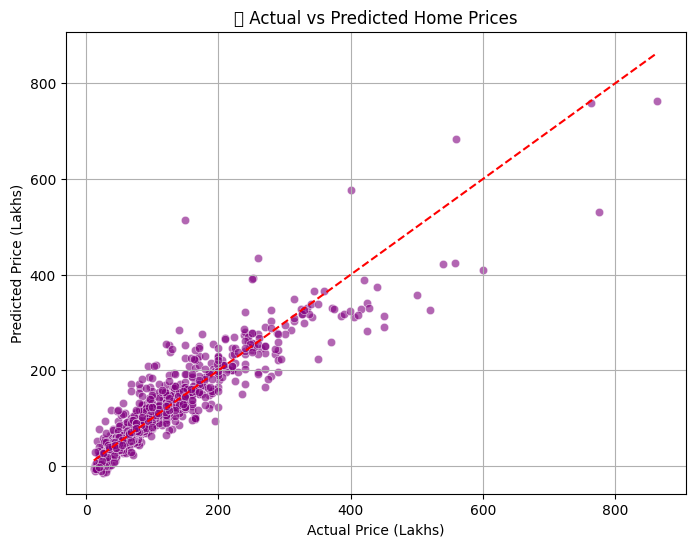

In [29]:
# Scatter plot of Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Diagonal line
plt.xlabel('Actual Price (Lakhs)')
plt.ylabel('Predicted Price (Lakhs)')
plt.title('🔍 Actual vs Predicted Home Prices')
plt.grid(True)
plt.show()


# Saving The Model

In [30]:
import joblib

# Save the model
joblib.dump(lr_model, 'linear_regression_model.pkl')

# Load the model
# loaded_model = joblib.load('linear_regression_model.pkl')


['linear_regression_model.pkl']

<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">Smash That Upvote !! Thanks ! 🚀😃</span>
